# Bragg Grating Sections

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FBraggGratings.ipynb).

In this example, sections of two Bragg gratings will be simulated. The first one involves a waveguide with a perfectly-aligned corrugation on either side, which acts as a reflector. The second one is similar, but with the corrugation on one side misaligned with the corrugation on the other side, so that the structure primarily transmits power.

Reference:  Xu Wang, Yun Wang, Jonas Flueckiger, Richard Bojko, Amy Liu, Adam Reid, James Pond, Nicolas A. F. Jaeger, and Lukas Chrostowski, "Precise control of the coupling coefficient through destructive interference in silicon waveguide Bragg gratings," Opt. Lett. 39, 5519-5522 (2014)

In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# tidy3d imports
import tidy3d as td

## Structure Setup


In [2]:
# materials
Air = td.Medium(permittivity=1.0)
Si = td.Medium(permittivity=3.47**2)
SiO2 = td.Medium(permittivity=1.44**2)
# SiO2 = td.material_library['SiO2']['Horiba']

# set basic geometric parameters
wg_height = 0.22
wg_feed_length = 0.75
wg_feed_width = 0.5
corrug_width = 0.05
num_periods = 20
period = 0.324

shift = period/2
corrug_length = period/2
wg_length = num_periods * period
wg_width = wg_feed_width - corrug_width

# wavelength / frequency setup
wavelength = 1.5397423672516397 / np.sqrt(Si.permittivity)
freq0 = td.C_0 / wavelength / np.sqrt(Si.permittivity)
wavelength0 = td.C_0 / freq0
fwidth = 43.940
run_time = 1250e-15
wavelength_min = td.C_0 / (freq0 + fwidth)

# place the two waveguides so that their centres are half a free-space wavelength apart
wg1_y = wavelength0 / 2
wg2_y = -wavelength0 / 2
wg_separation = wavelength0/2

# small buffer added to structures so they extend into the PML a bit
pml_buffer = period

# waveguide 1
wg1_size = [wg_length+pml_buffer, wg_width, wg_height]
wg1_center = [0, wg1_y, wg_height/2]
wg1_medium = Si

# waveguide 2
wg2_size = [wg_length+pml_buffer, wg_width, wg_height]
wg2_center = [0, wg2_y, wg_height/2]
wg2_medium = Si

# corrugation setup for waveguide 1
cg1_size = [corrug_length, corrug_width, wg_height]
cg1_center_plus = [-wg_length/2 + corrug_length/2, wg_width/2 + corrug_width/2 + wg1_y, wg_height/2]
cg1_center_minus = [-wg_length/2 + corrug_length/2, -wg_width/2 - corrug_width/2 + wg1_y, wg_height/2]
cg1_medium = Si

# corrugation setup for waveguide 2
cg2_size = [corrug_length, corrug_width, wg_height]
cg2_center_plus = [-wg_length/2 + corrug_length/2, wg_width/2 + corrug_width/2 + wg2_y, wg_height/2]
cg2_center_minus = [-wg_length/2 + corrug_length/2 + shift, -wg_width/2 - corrug_width/2 + wg2_y, wg_height/2]
cg2_medium = Si

# substrate
sub_size = [wg_length+wavelength0*0+pml_buffer, 2*wavelength0+wg_width+2*corrug_width+pml_buffer, 2]
sub_center = [0, 0, -1.0]
sub_medium = SiO2

# create the substrate
substrate = td.Structure(
    geometry=td.Box(
        center=sub_center,
        size=sub_size
    ),
    medium=sub_medium,
    name='substrate')

# create the first waveguide
waveguide_1 = td.Structure(
    geometry=td.Box(
        center=wg1_center,
        size=wg1_size
    ),
    medium=wg1_medium,
    name='waveguide_1')

# create the second waveguide
waveguide_2 = td.Structure(
    geometry=td.Box(
        center=wg2_center,
        size=wg2_size
    ),
    medium=wg2_medium,
    name='waveguide_2')

# create the corrugation for the first waveguide
corrug1_plus = []
corrug1_minus = []
for i in range(num_periods):
    # corrugation on the +y side
    center = cg1_center_plus
    if i > 0:
        center[0] += period
    plus = td.Structure(
        geometry=td.Box(
            center=center,
            size=cg1_size
        ),
        medium=cg1_medium,
        name=f"corrug1_plus_{i}")
    
    # corrugation on the -y side
    center = cg1_center_minus
    if i > 0:
        center[0] += period
    minus = td.Structure(
        geometry=td.Box(
            center=center,
            size=cg1_size
        ),
        medium=cg1_medium,
        name=f"corrug1_minus_{i}")

    corrug1_plus.append(plus)
    corrug1_minus.append(minus)

# create the corrugation for the second waveguide
corrug2_plus = []
corrug2_minus = []
for i in range(num_periods):
    # corrugation on the +y side
    center = cg2_center_plus
    if i > 0:
        center[0] += period
    plus = td.Structure(
        geometry=td.Box(
            center=center,
            size=cg2_size
        ),
        medium=cg2_medium,
        name=f"corrug2_plus_{i}")
    
    # corrugation on the -y side
    center = cg2_center_minus
    if i > 0:
        center[0] += period
    minus = td.Structure(
        geometry=td.Box(
            center=center,
            size=cg2_size
        ),
        medium=cg2_medium,
        name=f"corrug2_minus_{i}")

    corrug2_plus.append(plus)
    corrug2_minus.append(minus)

# full simulation domain
sim_size = [wg_length+wavelength0*0, 2*wavelength0+wg_width+2*corrug_width, 3.7]
sim_center = [0, 0, 0.0]

# boundary conditions - Bloch boundaries are used to emulate an infinitely long grating
boundary_spec=td.BoundarySpec(
    x=td.Boundary.bloch(bloch_vec=num_periods/2),
    y=td.Boundary.pml(),
    z=td.Boundary.pml()
)

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20)

## Source Setup


In [3]:
# mode source for waveguide 1
source1_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_src1 = td.ModeSource(
    center=[-wg_length/2 + 1.0*period, wg1_y, wg_height/2],
    size=[0, waveguide_1.geometry.size[1]*2, waveguide_1.geometry.size[2]*2],
    mode_index=0, direction='+',
    source_time=source1_time,
    mode_spec=td.ModeSpec()
    )

# mode source for waveguide 2
source2_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth, amplitude=4)
mode_src2 = td.ModeSource(
    center=[-wg_length/2 + 1.0*period, wg2_y, wg_height/2],
    size=[0, waveguide_2.geometry.size[1]*2, waveguide_2.geometry.size[2]*2],
    mode_index=0, direction='+',
    source_time=source2_time,
    mode_spec=td.ModeSpec()
    )

In [4]:
# create monitors
monitor_xy = td.FieldMonitor(
    center=[0, 0, wg_height/2],
    size=[wg_length, 2*wavelength0+wg_width+2*corrug_width, 0],
    freqs=[freq0],
    name='fields_xy')

[17:36:08] WARNING  Structure at structures[3] has bounds that extend       ]8;id=462956;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=807484;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[23] has bounds that extend      ]8;id=365452;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=387315;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[43] has bounds that extend      ]8;id=711784;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=508135;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[82] has bounds that extend      ]8;id=354090;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=798420;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           INFO     Auto meshing using wavelength 1.5397 defined from        ]8;id=828837;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=646943;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

<AxesSubplot:title={'center':'cross section at z=0.11'}, xlabel='x', ylabel='y'>

<Figure size 720x432 with 2 Axes>

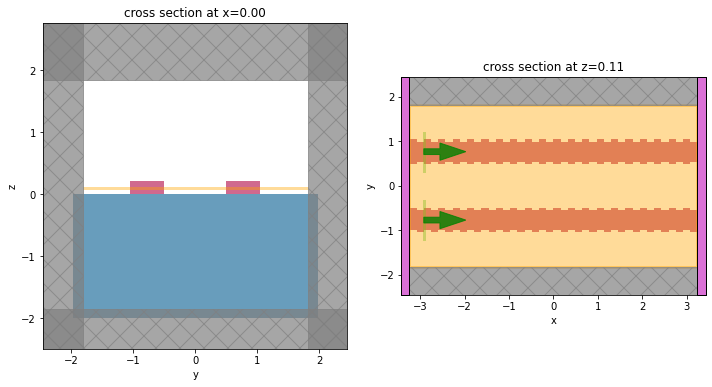

In [5]:
# list of all structures
structures = [substrate, waveguide_1, waveguide_2] + corrug1_plus + corrug1_minus + corrug2_plus + corrug2_minus

# list of all sources
sources = [mode_src1, mode_src2]

# list of all monitors
monitors = [monitor_xy]

# create the simulation
sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=grid_spec,
    structures=structures,
    sources=sources,
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec
)

# plot the simulation domain
f, (ax1, ax3) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 6))
sim.plot(x=0, ax=ax1)
sim.plot(z=wg_height/2, ax=ax3)

In [6]:
# run simulation
import tidy3d.web as web
sim_data = web.run(sim, task_name='bragg', path='data/bragg.hdf5')

[17:36:09] INFO     Using Tidy3D credentials from stored file                      ]8;id=133476;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=352764;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#74\74]8;;\

[17:36:11] INFO     Uploaded task 'bragg' with task_id                          ]8;id=98786;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=815026;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#117\117]8;;\
                    'b9fe3975-55f2-4792-ba08-1e81bbb24cc1'.                                  

Output()

[17:36:14] INFO     status = queued                                             ]8;id=938450;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=159976;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#258\258]8;;\

Output()

[17:36:22] INFO     status = preprocess                                         ]8;id=889267;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=4290;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#270\270]8;;\

[17:36:24] INFO     Maximum flex unit cost: 0.20                                ]8;id=190344;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=815145;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#249\249]8;;\

[17:36:29] INFO     starting up solver                                          ]8;id=481133;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=580326;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[17:36:39] INFO     running solver                                              ]8;id=86684;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=372595;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#280\280]8;;\

Output()

Output()

[17:37:37] INFO     status = postprocess                                        ]8;id=864960;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=35232;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#303\303]8;;\

[17:37:45] INFO     status = success                                            ]8;id=559545;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=426625;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#303\303]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=730435;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=517700;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#575\575]8;;\
                    "data/bragg.hdf5"                                                        

Output()

[17:37:48] INFO     loading SimulationData from data/bragg.hdf5                 ]8;id=588996;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=956888;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#397\397]8;;\

           WARNING  Structure at structures[16] has bounds that extend      ]8;id=775768;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=460938;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[23] has bounds that extend      ]8;id=993708;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=447340;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[38] has bounds that extend      ]8;id=41145;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=866571;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[81] has bounds that extend      ]8;id=874533;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=598889;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Simulation final field decay value of 0.627 is greater than ]8;id=181215;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=41335;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#403\403]8;;\
                    the simulation shutoff threshold of 1e-05. Consider                      
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

           INFO     Auto meshing using wavelength 1.5397 defined from        ]8;id=225890;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=3840;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

<AxesSubplot:title={'center':'cross section at z=0.00'}, xlabel='x', ylabel='y'>

<Figure size 360x504 with 2 Axes>

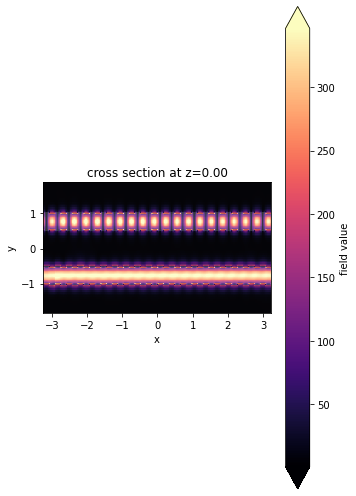

In [7]:
# plot fields on the monitor
fig, ax = plt.subplots(tight_layout=True, figsize=(5, 7))
sim_data.plot_field(field_monitor_name='fields_xy', field_name='Ey', val='abs', f=freq0, ax=ax)